# Github Activity Metrics-Issues

**Activity by Repo**

This notebook will aim to query the Augur DB to access the neccessary information to be able to get the following issue metrics dirived from the GitHub Community Metrics working document https://docs.google.com/document/d/1Yocr6fk0J8EsVZnJwoIl3kRQaI94tI-XHe7VSMFT0yM/edit?usp=sharing

Any necessary computations from the data to get the metric value will be done as the queries are determined

In [1]:
import psycopg2
import pandas as pd 
import sqlalchemy as salc
import json
import os
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (15, 5)

with open("../config_temp.json") as config_file:
    config = json.load(config_file)

In [2]:
database_connection_string = 'postgresql+psycopg2://{}:{}@{}:{}/{}'.format(config['user'], config['password'], config['host'], config['port'], config['database'])

dbschema='augur_data'
engine = salc.create_engine(
    database_connection_string,
    connect_args={'options': '-csearch_path={}'.format(dbschema)})

In [3]:
#add your repo name(s) here of the repo(s) you want to query if known (and in the database)
repo_name_set = ['augur', 'grimoirelab']
repo_set = []

for repo_name in repo_name_set:
    repo_query = salc.sql.text(f"""
                 SET SCHEMA 'augur_data';
                 SELECT 
                    b.repo_id
                FROM
                    repo_groups a,
                    repo b
                WHERE
                    a.repo_group_id = b.repo_group_id AND
                    b.repo_name = \'{repo_name}\'
        """)

    t = engine.execute(repo_query)
    repo_id =t.mappings().all()[0].get('repo_id')
    repo_set.append(repo_id)
print(repo_set)

[25440, 25448]


In [4]:
#Take this out of quotes if you want to manually assign a repo_id number(s)
#repo_set = [25440]

median time to close/merge PR 

Mean time to first response 
-Issues 
-PR

In [5]:
df_review = pd.DataFrame()

for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""
                SELECT
                    r.repo_name,
					prr.pr_review_id,
                    prr.pull_request_id,
					prr.pr_review_body,
					prr.pr_review_submitted_at
                FROM
                	repo r,
                    pull_requests pr,
                    pull_request_reviews prr
                WHERE
                    prr.pull_request_id = pr.pull_request_id AND
                	pr.repo_id = r.repo_id AND
                    r.repo_id = \'{repo_id}\'
        """)
    df_current_repo = pd.read_sql(pr_query, con=engine)
    df_review = pd.concat([df_review, df_current_repo])

df_review  = df_review.reset_index()
df_review .drop("index", axis=1, inplace=True)
        
df_review

,repo_name,pr_review_id,pull_request_id,pr_review_body,pr_review_submitted_at
0,augur,7139,210373,None,2020-03-22 15:46:22
1,augur,7140,213657,None,2020-06-22 17:57:57
2,augur,7141,218787,None,2020-12-16 10:33:17
3,augur,7142,218787,None,2020-12-16 11:08:06
4,augur,7143,218787,None,2020-12-16 10:47:03
...,...,...,...,...,...
860,grimoirelab,8304,219668,"Sorry, I should had been more clear. I think y...",2021-08-06 08:50:09
861,grimoirelab,8305,219668,LGTM,2021-08-06 10:33:30
862,grimoirelab,8618,213799,"LGTM, thanks!",2021-08-23 13:09:05
863,grimoirelab,8619,219761,Thanks for the PR @eyehwan.\r\nDo you think we...,2021-08-25 11:13:50


### Query for Pull Request Analysis

In [6]:
df_pr = pd.DataFrame()

for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""
                SELECT
                    r.repo_name,
					pr.pull_request_id AS pull_request, 
					pr.pr_created_at AS created, 
					pr.pr_closed_at AS closed,
					pr.pr_merged_at  AS merged 
                FROM
                	repo r,
                    pull_requests pr
                WHERE
                	r.repo_id = pr.repo_id AND
                    r.repo_id = \'{repo_id}\'
        """)
    df_current_repo = pd.read_sql(pr_query, con=engine)
    df_pr = pd.concat([df_pr, df_current_repo])

df_pr = df_pr.reset_index()
df_pr.drop("index", axis=1, inplace=True)
        
df_pr.head()

,repo_name,pull_request,created,closed,merged
0,augur,214028,2020-10-19 12:10:22,2020-10-19 13:27:26,NaT
1,augur,210011,2017-02-01 20:41:17,2017-02-02 16:51:16,2017-02-02 16:51:16
2,augur,210012,2017-02-01 21:43:24,2017-02-02 16:47:25,2017-02-02 16:47:25
3,augur,210019,2017-03-16 21:16:33,2017-03-16 21:17:07,2017-03-16 21:17:07
4,augur,210219,2019-10-23 22:27:53,2019-10-23 22:28:01,2019-10-23 22:28:01


### Query for Issue Analysis

In [7]:
df_issues = pd.DataFrame()

for repo_id in repo_set: 

    pr_query = salc.sql.text(f"""
                SELECT
                    r.repo_name,
					i.issue_id AS issue, 
					i.gh_issue_number AS issue_number,
					i.gh_issue_id AS gh_issue,
					i.created_at AS created, 
					i.closed_at AS closed
                FROM
                	repo r,
                    issues i
                WHERE
                	r.repo_id = i.repo_id AND
                    i.repo_id = \'{repo_id}\'
        """)
    df_current_repo = pd.read_sql(pr_query, con=engine)
    df_issues = pd.concat([df_issues, df_current_repo])

df_issues = df_issues.reset_index()
df_issues.drop("index", axis=1, inplace=True)
        
df_issues

,repo_name,issue,issue_number,gh_issue,created,closed
0,augur,340115,28,213149529,2017-03-09 20:06:18,2017-04-07 21:18:01
1,augur,343231,886,682259157,2020-08-20 00:09:30,2020-08-20 00:16:50
2,augur,343216,880,679627659,2020-08-15 19:11:45,2020-08-17 14:30:04
3,augur,343467,967,724668885,2020-10-19 14:21:08,2020-10-19 14:21:34
4,augur,342738,740,628534692,2020-06-01 15:34:33,2020-08-20 10:48:14
...,...,...,...,...,...,...
1889,grimoirelab,735294,437,941801983,2021-07-12 08:23:29,2021-07-28 08:58:49
1890,grimoirelab,735295,436,924259145,2021-06-17 19:24:54,NaT
1891,grimoirelab,340606,284,559853733,2020-02-04 17:00:31,NaT
1892,grimoirelab,734649,429,889819068,2021-05-12 08:28:28,NaT


In [8]:
#IF YOU ONLY WANT TO LOOK AT A ONE OF THE REPOS QUERIED 
repo_focus = 'augur'
df_issues_focus = df_issues[df_issues['repo_name'] == repo_focus]
df_issues_focus = df_issues_focus.sort_values(by= "created")
df_issues_focus = df_issues_focus.reset_index(drop=True)

In [9]:
df_issues_focus.head()

,repo_name,issue,issue_number,gh_issue,created,closed
0,augur,340142,1,202159788,2017-01-20 14:56:01,2017-12-18 17:15:12
1,augur,340141,2,202161717,2017-01-20 15:04:01,2017-02-17 03:05:14
2,augur,340140,3,202232128,2017-01-20 20:15:51,2017-02-15 16:55:41
3,augur,340139,4,202606858,2017-01-23 18:00:23,2017-05-11 15:45:33
4,augur,340138,5,202618154,2017-01-23 18:50:08,2017-01-23 20:49:42


#### Median Time to Close Issues
One of the performance metrics we would like to track is the median time taken to close issues. From the `issues` table, we have `created` and `closed` timestamps, the difference between the two will give us the time taken to close a given issue.

In [10]:
# Calculate the time taken to close an issue
df_issues_focus['time_to_close'] = (df_issues_focus.closed - df_issues_focus.created)

In [11]:
df_issues_focus.head()

,repo_name,issue,issue_number,gh_issue,created,closed,time_to_close
0,augur,340142,1,202159788,2017-01-20 14:56:01,2017-12-18 17:15:12,332 days 02:19:11
1,augur,340141,2,202161717,2017-01-20 15:04:01,2017-02-17 03:05:14,27 days 12:01:13
2,augur,340140,3,202232128,2017-01-20 20:15:51,2017-02-15 16:55:41,25 days 20:39:50
3,augur,340139,4,202606858,2017-01-23 18:00:23,2017-05-11 15:45:33,107 days 21:45:10
4,augur,340138,5,202618154,2017-01-23 18:50:08,2017-01-23 20:49:42,0 days 01:59:34


In [12]:
# The overal median time to close issues for the augur repo
df_issues_focus.time_to_close.median()

Timedelta('0 days 09:40:58')

Now let's find out the median time taken to close issues grouped by month.

In [13]:
df_issues_closed_monthly = df_issues_focus['time_to_close'].groupby(df_issues_focus.created.dt.to_period("M")).agg('median')

In [14]:
df_issues_closed_monthly = df_issues_closed_monthly.astype('timedelta64[D]')

We can visualize the trend in median time to close issues by month

Text(0.5, 1.0, 'Median Time to Close Issues (Monthly)')

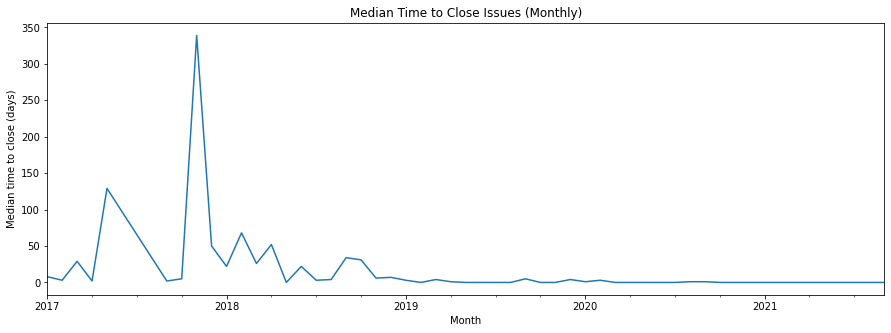

In [15]:
df_issues_closed_monthly.plot()
plt.xlabel("Month")
plt.ylabel("Median time to close (days)")
plt.title("Median Time to Close Issues (Monthly)")

In [16]:
df_issues_focus.describe()

,issue,issue_number,gh_issue,time_to_close
count,1450.000000,1450.000000,1.450000e+03,1351
mean,455746.498621,727.115172,6.276071e+08,17 days 00:29:38.954108068
std,179337.133918,421.067635,2.034626e+08,58 days 21:09:12.017033490
min,339455.000000,1.000000,2.021598e+08,0 days 00:00:07
25%,339817.250000,363.250000,4.869761e+08,0 days 00:02:16
50%,342718.500000,725.500000,6.255091e+08,0 days 09:40:58
75%,734421.750000,1088.750000,7.880436e+08,6 days 19:29:25
max,744146.000000,1464.000000,9.894753e+08,692 days 02:45:18


We can also plot a bar graph as follows

Text(0.5, 1.0, 'Median Time to Close Issues (Monthly)')

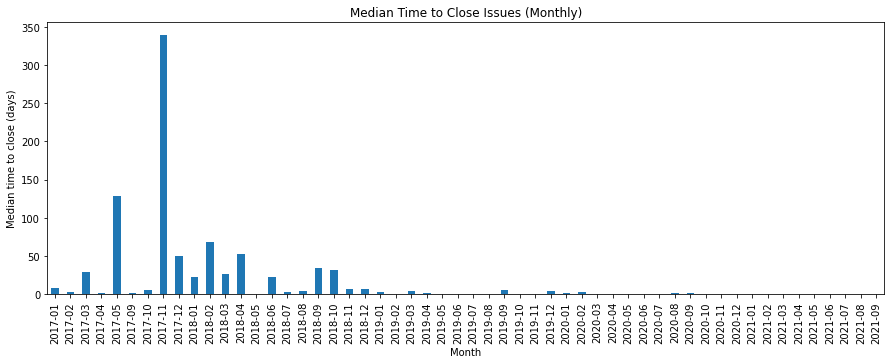

In [17]:
df_issues_closed_monthly.plot.bar()
plt.xlabel("Month")
plt.ylabel("Median time to close (days)")
plt.title("Median Time to Close Issues (Monthly)")

## Issues Open
Let's now identify the issues which are still open and find out the median time they have been open.

In [18]:
df_issues_open = df_issues_focus[df_issues_focus['closed'].isnull()]

In [19]:
df_issues_open = df_issues_open.reset_index(drop=True)

In [20]:
df_issues_open.head()

,repo_name,issue,issue_number,gh_issue,created,closed,time_to_close
0,augur,340907,690,603323904,2020-04-20 15:24:31,NaT,NaT
1,augur,343313,914,699378097,2020-09-11 14:21:07,NaT,NaT
2,augur,343312,915,699406255,2020-09-11 14:46:31,NaT,NaT
3,augur,343376,927,711054183,2020-09-29 12:15:30,NaT,NaT
4,augur,343372,931,711112935,2020-09-29 13:28:30,NaT,NaT


To find out how long an issue has been open, we can find the difference between the current timestamp and the issue creation timestamp

In [21]:
#Calculate the time an issue has been open
df_issues_open['time_open'] = (pd.Timestamp.now() - df_issues_open.created)

In [22]:
df_issues_open.head()

,repo_name,issue,issue_number,gh_issue,created,closed,time_to_close,time_open
0,augur,340907,690,603323904,2020-04-20 15:24:31,NaT,NaT,506 days 05:07:59.214896
1,augur,343313,914,699378097,2020-09-11 14:21:07,NaT,NaT,362 days 06:11:23.214896
2,augur,343312,915,699406255,2020-09-11 14:46:31,NaT,NaT,362 days 05:45:59.214896
3,augur,343376,927,711054183,2020-09-29 12:15:30,NaT,NaT,344 days 08:17:00.214896
4,augur,343372,931,711112935,2020-09-29 13:28:30,NaT,NaT,344 days 07:04:00.214896


In [23]:
df_issues_open.describe()

,issue,issue_number,gh_issue,time_to_close,time_open
count,99.000000,99.000000,9.900000e+01,0,99
mean,672842.717172,1260.282828,8.872820e+08,NaT,125 days 09:43:40.608835394
std,145450.403304,174.463378,9.534649e+07,NaT,118 days 05:11:04.798777578
min,340907.000000,690.000000,6.033239e+08,NaT,6 days 23:27:09.214896
25%,734421.500000,1179.500000,8.309510e+08,NaT,33 days 12:40:34.714896
50%,735131.000000,1319.000000,9.390820e+08,NaT,63 days 03:38:55.214896
75%,735215.500000,1402.500000,9.625623e+08,NaT,181 days 03:21:48.214896
max,744144.000000,1460.000000,9.856823e+08,NaT,506 days 05:07:59.214896


Now, lets see the median time issues were open by month

In [24]:
df_issues_open_monthly = df_issues_open['time_open'].groupby(df_issues_open.created.dt.to_period("M")).agg('median')

In [25]:
df_issues_open_monthly = df_issues_open_monthly.astype('timedelta64[D]')

We can visualize the median time issues are open with a bar graph

Text(0, 0.5, 'Median Time Open (days)')

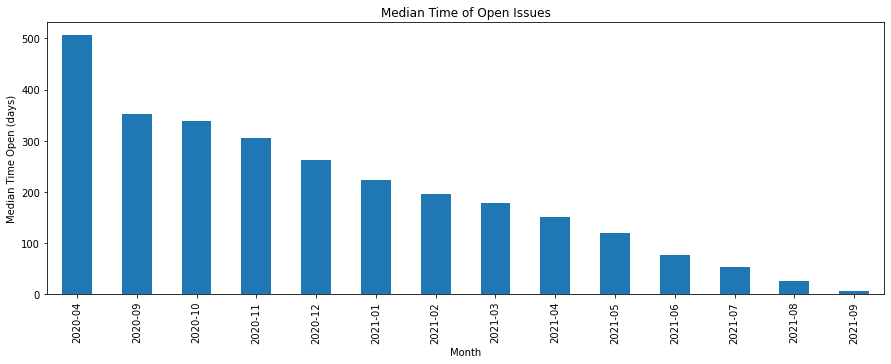

In [26]:
df_issues_open_monthly.plot.bar()
plt.title("Median Time of Open Issues")
plt.xlabel("Month")
plt.ylabel("Median Time Open (days)")